# Variational AutoEncoder example
This notebook is a copy of [Francois Chollet's example](https://keras.io/examples/generative/vae/) but modified for online learning. In particular, some goals are:
1. test computational performance scaling (CPUs, GPUs)
2. test model performance while saving and fitting again (in particular, adding more data instead of having all the data available at once).
3. integrations with DVC

## Environment set up
Based on the [Keras](https://keras.io/getting_started/) and [Tensorflow](https://www.tensorflow.org/install) instructions. We need Keras 3+ to be able to run this example. A simple `conda install tensorflow` will install TF 2.12 and Keras 2. I also tried using Python 3.11, but it appears that there may be some issues with underlying C libraries, so use Python 3.9:
+ `conda create --name tf-cpu-py39 python=3.9`

The following are required for connecting the kernel to a notebook:
+ `conda install -q -y requests`
+ `conda install -q -y ipykernel`
+ `conda install -q -y -c anaconda jinja2`
+ `conda install -q -y pandas matplotlib`

Ensure pip is up to date, then install TF:
+ `pip install --upgrade pip`
+ `pip install tensorflow`
+ `pip install tensorboard-plugin-profile`

## Performance results

4 CPUs -> 40 ms/step, ~22s per epoch

8 CPUs -> 24 ms/step, ~13s per epoch

T4 GPU -> ???

In [23]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [24]:
model_dir = './model_d'

os.makedirs(model_dir, exist_ok = True)
os.makedirs(model_dir + '/model', exist_ok = True)

## Create sampling layer

In [25]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

## Build the encoder

In [26]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3136)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │     50,192 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

## Build the decoder

In [27]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

## Define the VAE as a `Model` with a custom `train_step`

In [28]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train the VAE

In [29]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True) # stops training early if the validation loss does not improve

# Insert new cells to create data subsets
# Maybe plot data to check if it is a mix of different digits

In [31]:
# data subsets
count = 0

for arr in np.array_split(mnist_digits, 5):
    count += 1
    
    if os.path.exists(os.path.join(model_dir, 'vae.weights.h5')): # if the model has already been trained at least once, load that model
        vae.load_weights(os.path.join(model_dir, 'vae.weights.h5'))
        
    history = vae.fit(mnist_digits, epochs=30, batch_size=128, callbacks = [early_stopping_cb])
    
    vae.save_weights(os.path.join(model_dir, 'vae.weights.h5')) # save model weights after training
    
    hist_pd = pd.DataFrame(history.history)
    hist_pd.to_csv(os.path.join(model_dir, f'history_{count}.csv'), index = False)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 6.5958 - loss: 147.2921 - reconstruction_loss: 140.6964
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 6.6039 - loss: 147.8087 - reconstruction_loss: 141.2047
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 6.5876 - loss: 147.3737 - reconstruction_loss: 140.7861
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 6.5906 - loss: 147.1049 - reconstruction_loss: 140.5143
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 6.6014 - loss: 147.1039 - reconstruction_loss: 140.5025
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 6.6026 - loss: 146.9017 - reconstruction_loss: 140.2992
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 6.6103 - loss: 147.2370 - reconstruction_loss: 140.6267
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - kl_loss: 6.6209 - loss: 146.8802 - reconstruction_loss: 140.2594
Epoch 9/30
547/547 ━━━━━━━━━━━━━

## Display a grid of reconstructed digits in the latent space

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters digits

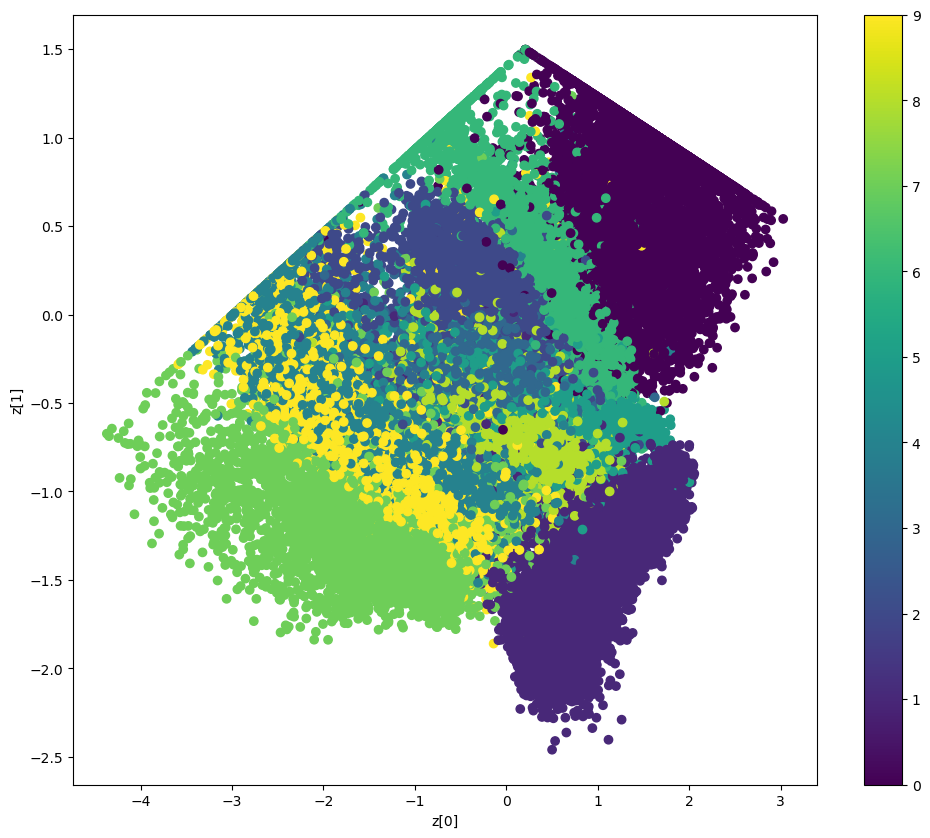

In [8]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)